In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


In [16]:
# Load the dataset
df = pd.read_csv('../statisticalinf/finaldata_onehotafterdropreefname.csv')
print("Dataset loaded successfully!")
print("\nFirst few rows of the dataset:")
df.head()

Dataset loaded successfully!

First few rows of the dataset:


,Year,Month,SST_MIN,SST_MAX,SST@90th_HS,SSTA@90th_HS,DHW_from_90th_HS>1,Salinity,pH_total,fCO2,...,Pseudosiderastrea,Seriatopora,Siderastrea,Stylophora,Symphyllia,Turbinaria,Reef_Andaman & Nicobar Islands,Reef_Gulf of Kachchh,Reef_Gulf of Mannar,Reef_Lakshadweep
0,1997,1,25.84,27.97,27.506129,-0.114306,0.0,32.698858,8.090811,337.889161,...,1,1,1,1,1,1,1,0,0,0
1,1997,1,19.55,24.16,23.115806,-0.477784,0.0,36.414020,8.062024,390.115140,...,1,0,1,0,1,1,0,1,0,0
2,1997,1,25.80,27.86,27.261613,-0.153584,0.0,33.580544,8.077757,342.993230,...,1,1,0,1,1,1,0,0,1,0
3,1997,1,27.29,28.72,28.250323,0.148526,0.0,34.979368,8.082115,359.636453,...,0,1,0,1,1,0,0,0,0,1
4,1997,2,25.54,27.73,27.328214,-0.461979,0.0,32.778389,8.093888,337.500289,...,1,1,1,1,1,1,1,0,0,0


In [17]:
# Prepare the data
X = df.drop(['Bleaching'], axis=1)
y = df['Bleaching']

In [18]:
# Split into train+val and test sets
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split train+val into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

In [19]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [20]:
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Validation set size: {X_val.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")


Training set size: 720 samples
Validation set size: 240 samples
Test set size: 240 samples


In [21]:

def evaluate_model_with_progress(model, X_train, X_val, X_test, y_train, y_val, y_test, model_name):
    train_accuracies = []
    val_accuracies = []
    
    if model_name == 'XGBoost':
        model = xgb.XGBClassifier(
            random_state=42,
            n_estimators=100,
            learning_rate=0.1,
            eval_metric='logloss',
            early_stopping_rounds=10
        )
        model.fit(
            X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],
            verbose=True
        )
        results = model.evals_result()
        train_accuracies = [1 - x for x in results['validation_0']['logloss']]
        val_accuracies = [1 - x for x in results['validation_1']['logloss']]
        
    elif model_name == 'LightGBM':
        # Main model training
        model = lgb.LGBMClassifier(
            random_state=42,
            n_estimators=100,
            learning_rate=0.1,
            verbose=0
        )
        model.fit(X_train, y_train)
        
        # Progress tracking
        train_accuracies = []
        val_accuracies = []
        
        for n_trees in range(1, 101):
            temp_model = lgb.LGBMClassifier(
                random_state=42,
                n_estimators=n_trees,
                learning_rate=0.1,
                verbose=0  # Correct placement of verbose
            )
            temp_model.fit(X_train, y_train)  # No verbose here
            
            train_pred = temp_model.predict(X_train)
            val_pred = temp_model.predict(X_val)
            train_accuracies.append(accuracy_score(y_train, train_pred))
            val_accuracies.append(accuracy_score(y_val, val_pred))
            
    else:  # Random Forest
        model = RandomForestClassifier(
            random_state=42,
            n_estimators=100,
            verbose=1
        )
        model.fit(X_train, y_train)
        
        for i in range(1, 101):
            model.n_estimators = i
            train_pred = model.predict(X_train)
            val_pred = model.predict(X_val)
            train_accuracies.append(accuracy_score(y_train, train_pred))
            val_accuracies.append(accuracy_score(y_val, val_pred))
    
    # Final evaluation
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    cm = confusion_matrix(y_test, y_pred)
    
    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Training')
    plt.plot(val_accuracies, label='Validation')
    plt.title(f'{model_name} Learning Curve')
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()
    
    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }




Evaluating XGBoost...
[0]	validation_0-logloss:0.14897	validation_1-logloss:0.22832
[1]	validation_0-logloss:0.13544	validation_1-logloss:0.21207
[2]	validation_0-logloss:0.12472	validation_1-logloss:0.20169
[3]	validation_0-logloss:0.11559	validation_1-logloss:0.19255
[4]	validation_0-logloss:0.10775	validation_1-logloss:0.18414
[5]	validation_0-logloss:0.10073	validation_1-logloss:0.17638
[6]	validation_0-logloss:0.09432	validation_1-logloss:0.17253
[7]	validation_0-logloss:0.08897	validation_1-logloss:0.16959
[8]	validation_0-logloss:0.08469	validation_1-logloss:0.16775
[9]	validation_0-logloss:0.08037	validation_1-logloss:0.16474
[10]	validation_0-logloss:0.07668	validation_1-logloss:0.16305
[11]	validation_0-logloss:0.07279	validation_1-logloss:0.16403
[12]	validation_0-logloss:0.06955	validation_1-logloss:0.16105
[13]	validation_0-logloss:0.06632	validation_1-logloss:0.16228
[14]	validation_0-logloss:0.06370	validation_1-logloss:0.15986
[15]	validation_0-logloss:0.06060	validati

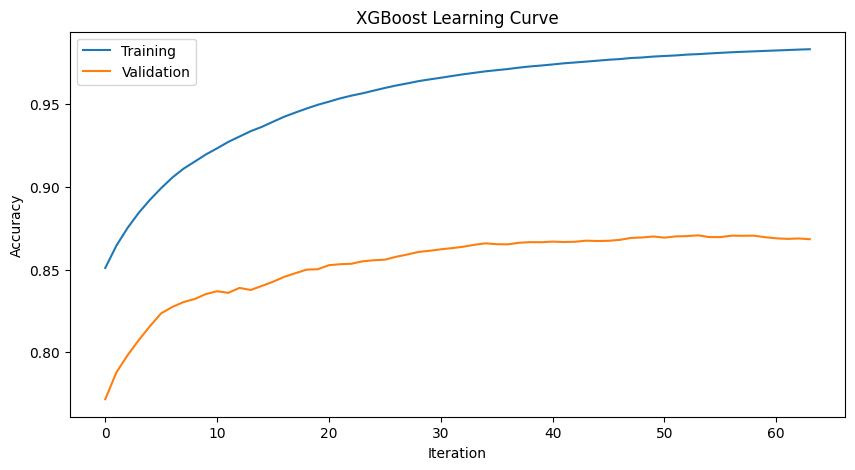

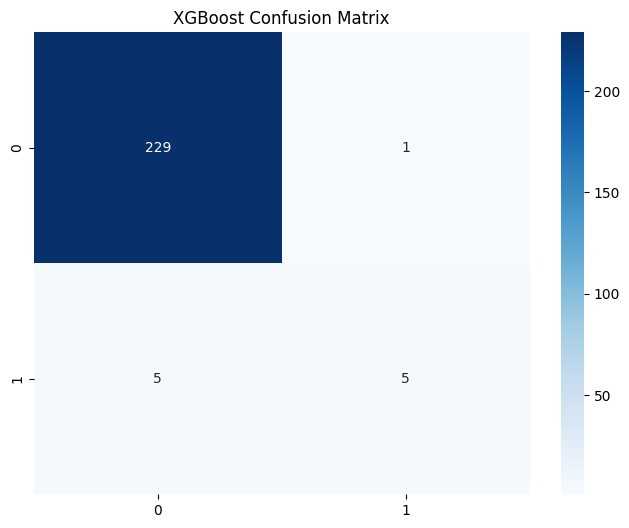


Evaluating Random Forest...


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

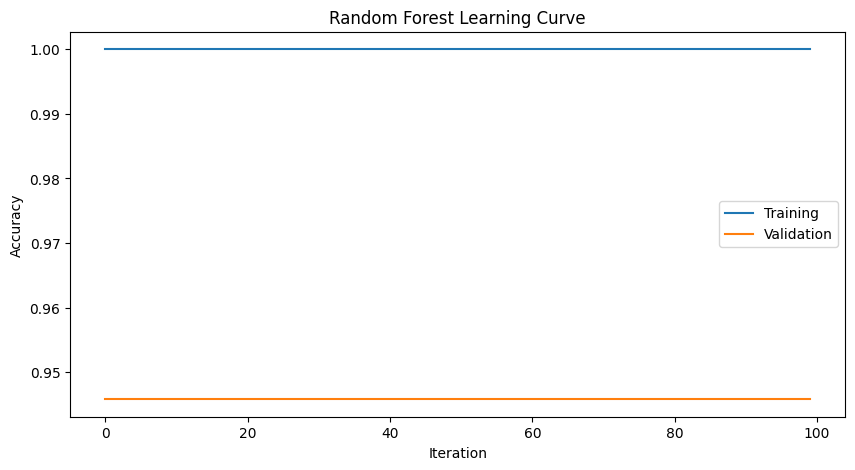

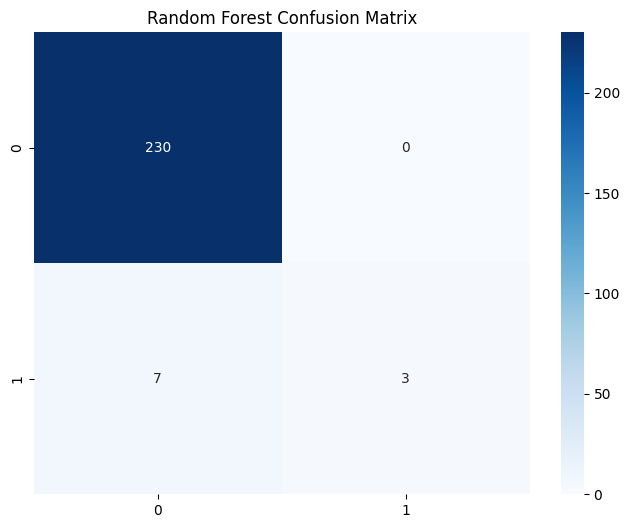


Evaluating LightGBM...
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

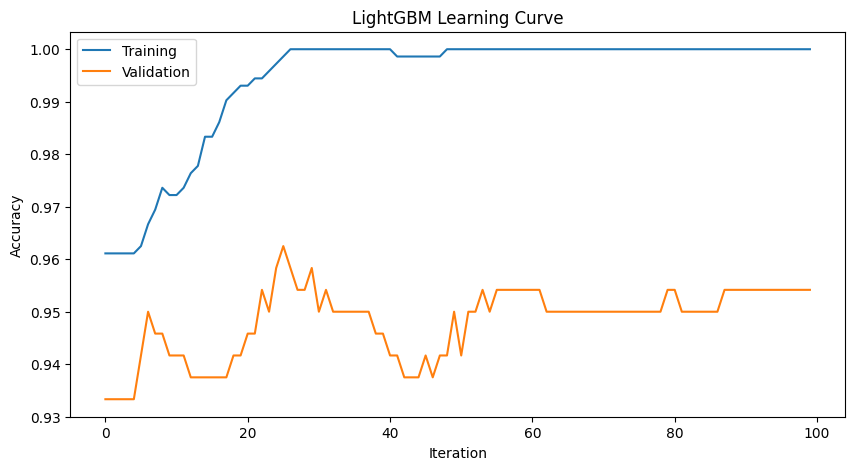

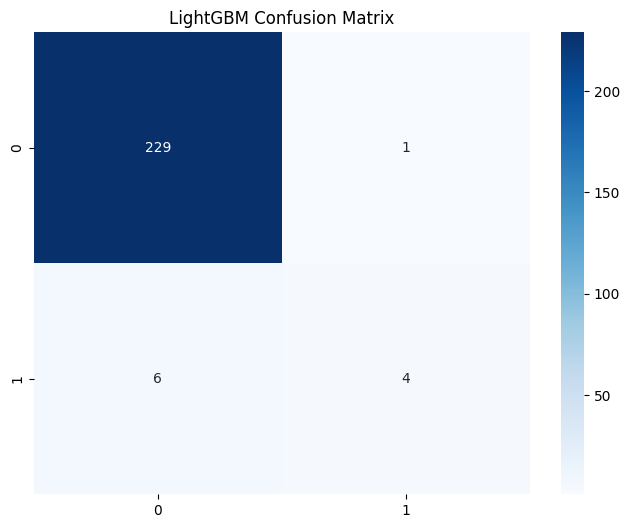


Final Results:
           Model  Accuracy  Precision  Recall  F1 Score
0        XGBoost  0.975000   0.833333     0.5  0.625000
1  Random Forest  0.970833   1.000000     0.3  0.461538
2       LightGBM  0.970833   0.800000     0.4  0.533333


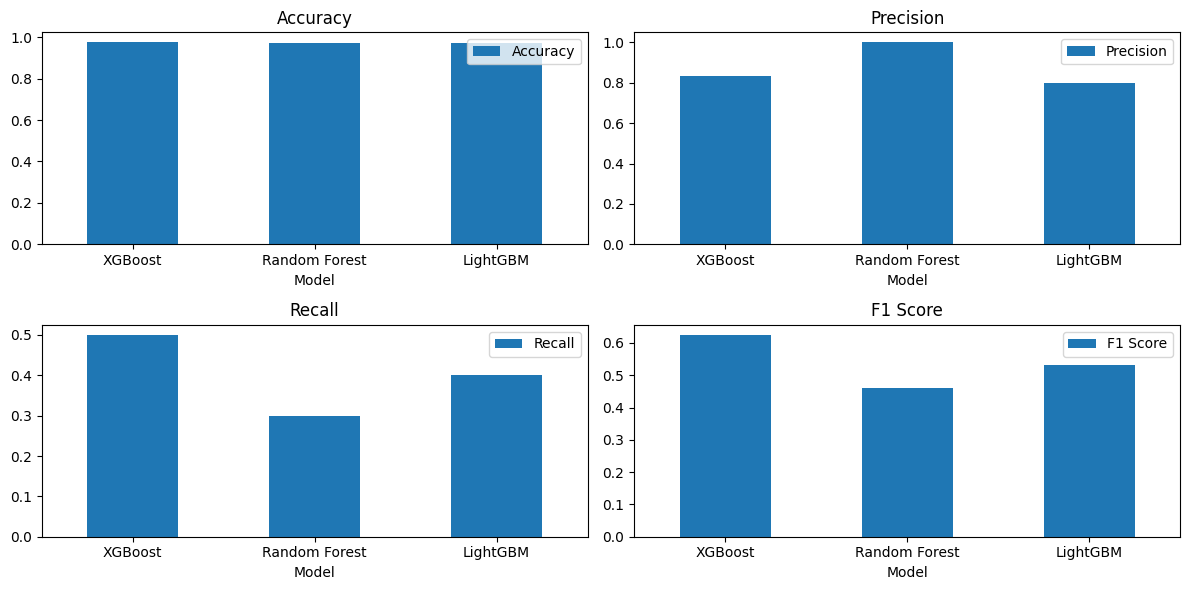

In [22]:
# Initialize and evaluate models
results = []
for model, name in [(xgb.XGBClassifier(), 'XGBoost'), 
                    (RandomForestClassifier(), 'Random Forest'), 
                    (lgb.LGBMClassifier(), 'LightGBM')]:
    print(f"\nEvaluating {name}...")
    result = evaluate_model_with_progress(
        model, X_train_scaled, X_val_scaled, X_test_scaled,
        y_train, y_val, y_test, name
    )
    results.append(result)

# Results comparison
results_df = pd.DataFrame(results)
print("\nFinal Results:")
print(results_df)

# Metric comparison plot
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
plt.figure(figsize=(12, 6))
for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i+1)
    results_df.plot.bar(x='Model', y=metric, rot=0, ax=plt.gca())
    plt.title(metric)
plt.tight_layout()
plt.show()